In [1]:
# Step 1: Reinstallazione delle librerie necessarie
!pip uninstall transformers -y
!pip uninstall accelerate -y
!pip install transformers[torch]
!pip install accelerate -U
!pip install aiohttp
!pip install datasets
!pip install torch

# Step 2: Importazione delle librerie
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
import torch
import json
import re
from tqdm import tqdm

Found existing installation: transformers 4.41.2
Uninstalling transformers-4.41.2:
  Successfully uninstalled transformers-4.41.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 15.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.6/302.6 kB 17.0 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# GET THE DATASET DIVERSEVUL
f = open('/content/drive/MyDrive/DiverseVul_AST_secondo.json')
data = json.load(f)
dv = pd.DataFrame(data)
dv.info()
dv.groupby('target').describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21546 entries, 0 to 21545
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   func    21546 non-null  object
 1   target  21546 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 336.8+ KB


func                                                                
        count unique                                                top  freq
target                                                                       
0       10630   7778  `-FunctionDecl \n  |-ParmVarDecl \n  |-ParmVar...   648
1       10916   7201  `-FunctionDecl \n  |-ParmVarDecl \n  |-ParmVar...  1109

In [4]:
import pandas as pd
import re

df=dv.copy()

# Funzione per sostituire \n con spazio
def replace_newlines(text):
    return text.replace('\n', ' ')

# Funzione per contare i token
def count_tokens(text):
    tokens = re.findall(r'\w+', text)
    return len(tokens)

# Sostituire \n con spazio
df['func'] = df['func'].apply(replace_newlines)

# Filtrare le righe con un numero di token minore di 5 o maggiore di 256
df = df[df['func'].apply(count_tokens).between(5, 256)]

# Contare le entry dopo il pre-processing
numero_di_entry = dv.shape[0]
numero_di_entry_dopo = df.shape[0]

# Mostrare il numero di entry
print(f"Numero di entry prima il pre-processing: {numero_di_entry}")
print(f"Numero di entry dopo il pre-processing: {numero_di_entry_dopo}")

Numero di entry prima il pre-processing: 21546
Numero di entry dopo il pre-processing: 18697


In [5]:
prima_entry_func = dv['func'].iloc[0]
print(f"Prima: {prima_entry_func}")

dopo_entry_func = df['func'].iloc[0]
print(f"Dopo: {dopo_entry_func}")

Prima: `-FunctionDecl 
  |-ParmVarDecl 
  |-BuiltinAttr 
  |-NoThrowAttr 
  `-ConstAttr 

Dopo: `-FunctionDecl    |-ParmVarDecl    |-BuiltinAttr    |-NoThrowAttr    `-ConstAttr  


In [6]:
union = df.copy()
vv = df[df['target'] == 1]
nv = df[df['target'] == 0]

# Check the lengths of the subsets
len_vv = len(vv)
len_nv = len(nv)

# Sample from the subset with fewer rows
if len_nv >= len_vv:
    nv_sample = nv.sample(n=len_vv, replace=False)
else:
    nv_sample = nv.sample(n=len_nv, replace=False)
    vv = vv.sample(n=len_nv, replace=False)

# Concatenate the sampled dataframes
union = pd.concat([vv, nv_sample])

# Shuffle the resulting dataframe
union = union.sample(frac=1).reset_index(drop=True)

In [7]:
df=union.copy()
# SPLIT IN 3 SET AND STRATITY
df_v = df[df['target']==1]
split1 = int(len(df_v)*0.9)
split2 = int(len(df_v)*0.95)
df_v_train= df_v[:split1]
df_v_valid= df_v[split1:split2]
df_v_test = df_v[split2:]

df_n = df[df['target']==0]
split1 = int(len(df_n)*0.9)
split2 = int(len(df_n)*0.95)
df_n_train= df_n[:split1]
df_n_valid= df_n[split1:split2]
df_n_test = df_n[split2:]

# MERGE AND SHUFFLE ITEMS
df_train = pd.concat([df_v_train,df_n_train])
df_train = df_train.sample(frac = 1)
df_valid = pd.concat([df_v_valid,df_n_valid])
df_valid = df_valid.sample(frac = 1)
df_test  = pd.concat([df_v_test, df_n_test])
df_test  = df_test.sample(frac = 1)

print("TOTAL:",len(df))

print("TRAIN VUL    :",len(df_train[df_train['target']==0]))
print("TRAIN NON VUL:",len(df_train[df_train['target']==1]))
print("VALID VUL    :",len(df_valid[df_valid['target']==0]))
print("VALID NON VUL:",len(df_valid[df_valid['target']==1]))
print("TEST VUL     :",len(df_test[df_test['target']==0]))
print("TEST NON VUL :",len(df_test[df_test['target']==1]))

TOTAL: 18590
TRAIN VUL    : 8365
TRAIN NON VUL: 8365
VALID VUL    : 465
VALID NON VUL: 465
TEST VUL     : 465
TEST NON VUL : 465


In [8]:
train_dataset = Dataset.from_pandas(df_train)
val_dataset = Dataset.from_pandas(df_valid)
test_dataset = Dataset.from_pandas(df_test)

In [9]:
# Step 4: Tokenizzazione
tokenizer = AutoTokenizer.from_pretrained("microsoft/CodeGPT-small-py")

def preprocess_function(examples):
    # Tokenizza i dati e includi le etichette (labels)
    inputs = tokenizer(examples['func'], truncation=True, padding='max_length', max_length=256)
    inputs['labels'] = examples['target']
    return inputs

train_dataset = train_dataset.map(preprocess_function, batched=True)
val_dataset = val_dataset.map(preprocess_function, batched=True)
test_dataset = test_dataset.map(preprocess_function, batched=True)

# Step 5: Caricamento del modello
model = AutoModelForSequenceClassification.from_pretrained("microsoft/CodeGPT-small-py", num_labels=2)

# Step 6: Definizione degli argomenti di addestramento
training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/output/',
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    save_total_limit=1,           # Salva solo il modello finale
    save_steps=10000,             # Imposta un valore molto alto per save_steps
)

# Step 7: Definizione del Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,  # Utilizza il set di validazione
)




/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/175 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/610 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/865k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/424k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/16.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/380 [00:00<?, ?B/s]

Map:   0%|          | 0/16730 [00:00<?, ? examples/s]

Map:   0%|          | 0/930 [00:00<?, ? examples/s]

Map:   0%|          | 0/930 [00:00<?, ? examples/s]

pytorch_model.bin:   0%|          | 0.00/510M [00:00<?, ?B/s]

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at microsoft/CodeGPT-small-py and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [11]:
# Step 8: Addestramento del modello
trainer.train()


Epoch,Training Loss,Validation Loss
1,0.672500,0.670907
2,0.670900,0.670843
3,0.653500,0.674688


TrainOutput(global_step=6276, training_loss=0.6723074393336221, metrics={'train_runtime': 2698.139, 'train_samples_per_second': 18.602, 'train_steps_per_second': 2.326, 'total_flos': 6656534721331200.0, 'train_loss': 0.6723074393336221, 'epoch': 3.0})

In [12]:

# Step 9: Valutazione del modello
results = trainer.evaluate(eval_dataset=test_dataset)  # Utilizza il set di test per la valutazione finale
print(results)

{'eval_loss': 0.6618290543556213, 'eval_runtime': 15.5635, 'eval_samples_per_second': 59.755, 'eval_steps_per_second': 7.518, 'epoch': 3.0}


Shape of predictions.predictions: (930, 2)
Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.55      0.58       465
           1       0.60      0.67      0.63       465

    accuracy                           0.61       930
   macro avg       0.61      0.61      0.61       930
weighted avg       0.61      0.61      0.61       930



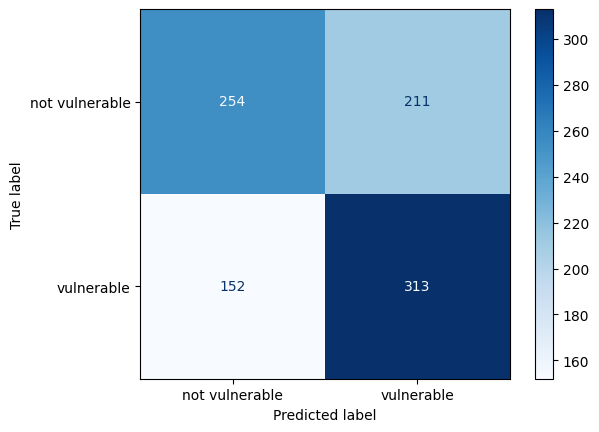

In [13]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

# Step 10: Valutazione del modello su set di test
predictions = trainer.predict(test_dataset)

# Verify the shape of predictions.predictions
print("Shape of predictions.predictions:", predictions.predictions.shape)

# Determine the correct axis for np.argmax based on the shape of the predictions
if len(predictions.predictions.shape) == 1:
    # If predictions are one-dimensional, take argmax directly
    predicted_labels = np.argmax(predictions.predictions)
else:
    # If predictions are two-dimensional, take argmax along the correct axis
    predicted_labels = np.argmax(predictions.predictions, axis=1)

true_labels = test_dataset['labels']

# Step 11: Stampa del classification report
print("Classification Report:")
print(classification_report(true_labels, predicted_labels))

target_names = ['not vulnerable', 'vulnerable']

# Calcola la matrice di confusione
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Visualizza la matrice di confusione
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=target_names)
disp.plot(cmap=plt.cm.Blues)
plt.show()




In [17]:
import numpy as np


# Salvataggio dell'array NumPy
np.save('/content/drive/MyDrive/codeGPT_AST_predictions.npy', predicted_labels)

# Carica il file numpy con allow_pickle=True
predicted_labels2 = np.load('/content/drive/MyDrive/codeGPT_AST_predictions.npy', allow_pickle=True)

predicted_labels2

array([0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1,
       1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1,
       0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0,
       1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0,
       1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0,
       0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0,
       1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0,
       0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0,
       0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0,
       1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1,
       1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1,

In [18]:
import pandas as pd

# Salva il DataFrame in formato JSON
df_test.to_json('/content/drive/MyDrive/df_test_AST.json')
df_train.to_json('/content/drive/MyDrive/df_train_AST.json')
df_valid.to_json('/content/drive/MyDrive/df_valid_AST.json')